<a href="https://colab.research.google.com/github/nmermigas/PyTorch/blob/main/08_paper_replicating_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating

Actual Goal: Turn ML research into ussable code.
We are going to replicate Vision Transformer (ViT) paper. https://arxiv.org/abs/2010.11929

## 0. Get Setup
We are going to use the code from going_modular (05 notebook).

In [6]:
import torch
import torchvision

torch.__version__,torchvision.__version__

('2.1.0+cu118', '0.16.0+cu118')

In [7]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [8]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

The whole goal is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need the data we have been using so far.

In [9]:
# Download pizza, steak, sushi images from Github
image_path = download_data(source ="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [10]:
# Setup directory paths for training and test
train_dir = image_path /'train'
test_dir = image_path /'test'

## 2. Create Datasets and DataLoaders


### 2.1 Create image size, Batch size and transform (manual)


In [11]:
from going_modular.going_modular import data_setup

IMAGE_SIZE = 224 # can be found at table 3 of the ViT paper.
BATCH_SIZE = 32 # in the paper is 4096, but we do not have that much computing power

# Create transforms pipeline
manual_transforms = transforms.Compose([transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
                                        transforms.ToTensor()])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)

### 2.2 Create DataLoaders


In [12]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader),len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image.

In [20]:
# iterate through the train_dataloader and visualize one single image
# Get the image batch
image_batch , label_batch = next(iter(train_dataloader))

# Get a single image from the batch

image, label = image_batch[0], label_batch[0]

# View the image and label shapes
image.shape, label.shape

(torch.Size([3, 224, 224]), torch.Size([]))

(-0.5, 223.5, 223.5, -0.5)

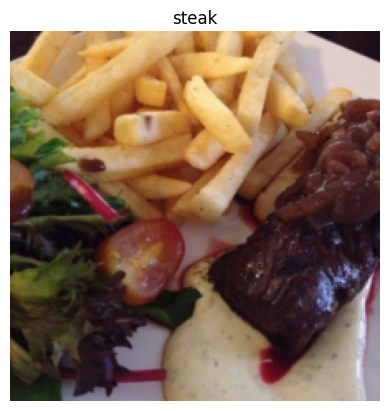

In [21]:
# Plot the image
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0)) # (color_channels, h,w) -> (h,w, color_channels)
plt.title(class_names[label])
plt.axis(False)

### 3. Replicating ViT: Overview

Looking at a whole ML research aper can be intimidating.

So in order to make it more understatable, we break it down into smaller pieces.

* **Inputs** - What goes into the model (in our case, image tensors (batches))
* **Outputs** - What come out of the model/layer/block ? (in our case: Classification labels)
* **Layers** - Takes an input, manipulates it with a function (e.g self-attention)
* **Block** - A collection of layers
* **Model** - A collection of blocks

### 3.1 ViT overview: "gathering the pieces"

* Figure 1: Visual overview of the architecture
* 4 equations: Math equations that define the functions of each layer/block
* Table 1: different hyperparameters for the architecture/training.
* Text

#### Figure 1
![picture](https://drive.google.com/file/d/1g03SePH4WFA6D5x5qVRX8GXJm853wM8U/view?usp=drive_link)

* Embedding = learning representation (random in the beggining and imporve over time)

#### 4 Equations
![picture](/content/vit_equations.png)

#### Table 1
![picture](/content/vit_figure.png)

